In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

data_dir = 'data'

In [23]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'), low_memory=False)
print(f'Columns: {df.columns}')

Columns: Index(['TAU_bl', 'PTAU_bl', 'ABETA_bl', 'PTEDUCAT', 'MMSE_bl',
       'EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl',
       'RAVLT_immediate_bl',
       ...
       'SUVr_Vermis_1_2.nii', 'SUVr_Vermis_3.nii', 'SUVr_Vermis_4_5.nii',
       'SUVr_Vermis_6.nii', 'SUVr_Vermis_7.nii', 'SUVr_Vermis_8.nii',
       'SUVr_Vermis_9.nii', 'SUVr_Vermis_10.nii', 'SUVr_VTA_L.nii',
       'SUVr_VTA_R.nii'],
      dtype='object', length=178)



TODO: Use a Gaussian Process Regressor with L1/L2/(L1+L2) Regularization + Adam/AdamW/SGD+Momentum

Predict ABETA_bl

In [ ]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['ABETA_bl']
# Calculate the correlation coefficient for each column in X with respect to ABETA_bl and use the inverse as the length scale for the corresponding feature
length_scales = np.array([1 / np.corrcoef(X[col], y).mean() if np.corrcoef(X[col], y).mean() != 0 else 1.0 for col in X.columns], dtype=np.float32)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

kernel = (1.0 * RBF(length_scale=length_scales, length_scale_bounds=(1e1, 1e3))
          # + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
          )

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=5e-1, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

gpr.fit(X_train, y_train)

Training set performance

In [ ]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)

# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# plt.fill_between(
#     y_train,
#     y_mean_train - 1.96 * y_std_train,
#     y_mean_train + 1.96 * y_std_train,
#     color='gray',
#     alpha=0.2,
# )
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'k--',
    lw=2,
    label='Perfect prediction',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

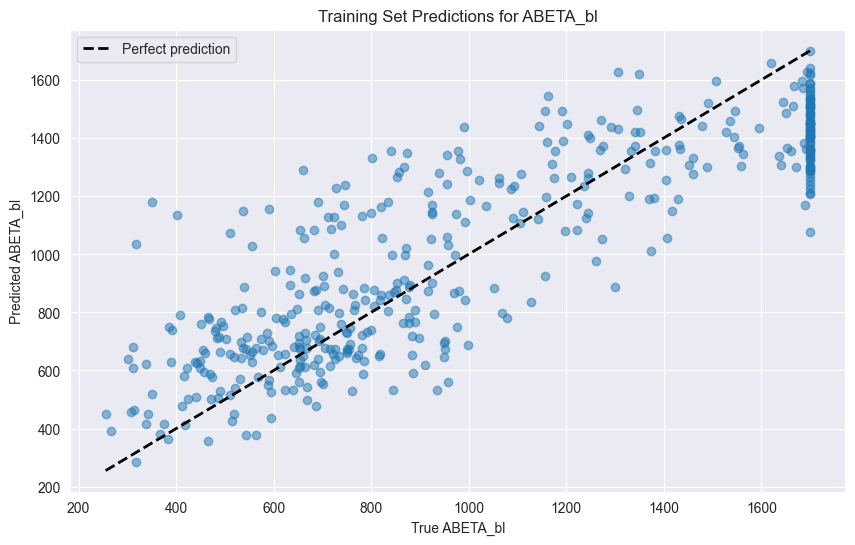

Training MSE: 57372.99
Training R^2: 0.72


In [113]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std=True)

# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_mean_train, alpha=0.5)
# plt.fill_between(
#     y_train,
#     y_mean_train - 1.96 * y_std_train,
#     y_mean_train + 1.96 * y_std_train,
#     color='gray',
#     alpha=0.2,
# )
plt.plot(
    [y_train.min(), y_train.max()],
    [y_train.min(), y_train.max()],
    'k--',
    lw=2,
    label='Perfect prediction',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_train = mean_squared_error(y_train, y_mean_train)
r2_train = r2_score(y_train, y_mean_train)
print(f'Training MSE: {mse_train:.2f}')
print(f'Training R^2: {r2_train:.2f}')

Testing set performance

In [ ]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)

# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# plt.fill_between(
#     y_test,
#     y_mean_test - 1.96 * y_std_test,
#     y_mean_test + 1.96 * y_std_test,
#     color='gray',
#     alpha=0.2,
# )
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--',
    lw=2,
    label='Perfect prediction',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

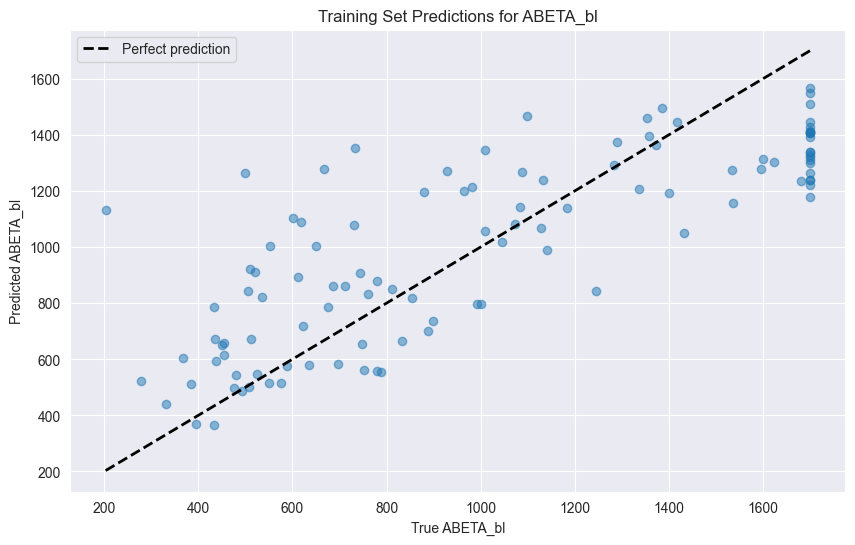

Testing MSE: 83838.36
Testing R^2: 0.63


In [109]:
y_mean_test, y_std_test = gpr.predict(X_test, return_std=True)

# Plot training set predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_mean_test, alpha=0.5)
# plt.fill_between(
#     y_test,
#     y_mean_test - 1.96 * y_std_test,
#     y_mean_test + 1.96 * y_std_test,
#     color='gray',
#     alpha=0.2,
# )
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'k--',
    lw=2,
    label='Perfect prediction',
)
plt.xlabel('True ABETA_bl')
plt.ylabel('Predicted ABETA_bl')
plt.title('Training Set Predictions for ABETA_bl')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_mean_test)
r2_test = r2_score(y_test, y_mean_test)

print(f'Testing MSE: {mse_test:.2f}')
print(f'Testing R^2: {r2_test:.2f}')

Predict PTAU_bl

In [ ]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['PTAU_bl']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

Predict TAU_bl

In [ ]:
X = df.drop(['ABETA_bl', 'PTAU_bl', 'TAU_bl'], axis=1)
y = df['TAU_bl']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)